<a href="https://colab.research.google.com/github/macorony/NeuralNetwork/blob/main/train_model_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [30]:
device = ('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [33]:
transform = transforms.Compose([transforms.ToTensor()])

In [34]:
train_data = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [35]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

In [46]:
random_sample = iter(train_loader)
images, labels = next(random_sample)

In [47]:
image_grid = torchvision.utils.make_grid(images)

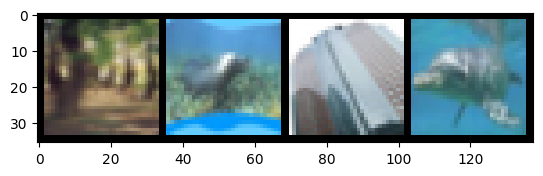

In [48]:
plt.imshow(image_grid.permute(1,2,0))

In [50]:
torchvision.datasets.CIFAR100

torchvision.datasets.cifar.CIFAR100